# Data Integration and Reshaping

Environment: Python 3.6.5 and Jupyter notebook
Libraries used: 
* pandas - for dataframe manipulation 
* shapefile - to read shapefiles 
* geopandas - to read and manipulate shapefile for co-ordinate reference system 
* matplotlib (for plotting)
* math - for mathematical functions
* Sklearn libraries - for data transformation and fitting linear model

## 1. Introduction
This analysis deals with Data Integration and Reshaping problems for Property data. 
    
    Task 1:The goal of the analysis is to find several relavant commute details about properties using GTFS data provided. 
    
    Task 2: The goal of the analysis is to study the effect of different normalization/transformation methods (i.e.standardization, min-max normalization, log, power, and root transformation) on Rooms,crime_C_average, travel_min_to_CBD, and property_age attributes. Also need to observe and explain their effect assuming that we want to build a linear model on price using these attributes as the predictors of the linear model and recommend which one(s) do you think would work better on this data. When building the linear model, the same normalization/transformation method can be applied to each of these attributes.


### Task 1: Data Integration 

Loading Libraries and reading properties datafile.

In [2]:
# importing libraries
import pandas as pd
import shapefile
import geopandas as gp
from shapely.geometry import Point
from math import *
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

%matplotlib inline

In [3]:
# Read file
data = pd.read_csv("data.csv")

In [4]:
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290
1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720
2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190
3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330
4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463


Finding duplicates and removing from data

In [5]:
# Finding number of duplicates
print("Number of duplicate entries: ",len(data[data.duplicated(keep='first')]))

Number of duplicate entries:  45


In [6]:
# Dropping duplicate Values
data = data.drop_duplicates(keep='first')
data = data.reset_index()

Finding valaues for various fields as per specification

### Suburb

Creating new column by converting lat,long information into POINT format to compare with Shape file

In [7]:
# Creating point column
data['point'] = data[['Longtitude','Lattitude']].apply(lambda x: Point(x['Longtitude'],x['Lattitude']), axis=1)
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,point
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290,POINT (145.1029 -37.7923)
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720,POINT (145.0972 -37.864)
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190,POINT (145.0219 -37.8545)
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330,POINT (144.9433 -37.7187)
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463,POINT (145.05463 -37.89334)


Reading Victoria's localities shapefile, that defines the boundries for different suburbs. GeoJSON library is used here.

In [8]:
# reading shapefile
sfdf = gp.read_file("VIC_LOCALITY_POLYGON_shp.shp")
sfdf.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


Finding suburbs from shapefile by doing a spatial join provided by geojson library.
* set the data file's Coordinate Reference System (CRS) to be same as the shapefile
* sjoin checks property's point lies in which suburb polygon and left joins it to the main dataframe

In [9]:
data = gp.GeoDataFrame(data, geometry='point')
data.crs = sfdf.crs

data = gp.sjoin(data, sfdf[['geometry','VIC_LOCA_2']], how='left')

#merged = PointsGeodataframe.merge(PolygonsGeodataframe, left_on='iso_alpha2', right_on='ISO2', how='left')
data = pd.DataFrame(data)
data.rename(columns = {'VIC_LOCA_2':'Suburb'},inplace = True)
data.drop(columns=['point','index_right'], axis=1, inplace=True)

In [10]:
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290,BALWYN NORTH
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720,ASHWOOD
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190,ARMADALE
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330,PASCOE VALE
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463,CARNEGIE


### Train station ID
Finding the train station closest to the property which has a direct trip to Southern Cross station on weekdays betweek 7am to 9.30 pm. 

First reading the GTFS data. GTFS data contains information about the transit system - routes, timings, trips, stop times, stations and schedules. Using folders 1 and 2 only for train information (Rest contain data about other modes of transport).

In [11]:
# Reading GTFS data from file 1 and 2
calendar = pd.DataFrame()
stop_times = pd.DataFrame()
stops = pd.DataFrame()
trips = pd.DataFrame()

gtfs_folders = [1,2]
for folder in gtfs_folders:
    calendar_df = pd.read_csv("gtfs/"+ str(folder) +"/google_transit/calendar.txt")
    stop_times_df = pd.read_csv("gtfs/"+ str(folder) +"/google_transit/stop_times.txt")
    stops_df = pd.read_csv("gtfs/"+ str(folder) +"/google_transit/stops.txt")
    trips_df = pd.read_csv("gtfs/"+ str(folder) +"/google_transit/trips.txt")
    
    # merging data 
    calendar = pd.concat([calendar, calendar_df], ignore_index=True)
    stop_times = pd.concat([stop_times, stop_times_df], ignore_index=True)
    stops = pd.concat([stops, stops_df], ignore_index=True)
    trips = pd.concat([trips, trips_df], ignore_index=True)

* Using stops file to find stopID for Southern Cross Railway Station and store it.

In [12]:
# Getting stopIDs for Southern Cross Railway Station
SC_stop_ids = stops[stops.stop_name=="Southern Cross Railway Station (Melbourne City)"].stop_id.unique()
SC_stop_ids

array([20043, 22180], dtype=int64)

* Find service ID that denotes the service IDs for weekdays

In [13]:
# getting service IDs for weekdays 
wkdays_servids = set(calendar[(calendar.monday==1)&(calendar.tuesday==1)&(calendar.wednesday==1)&(calendar.thursday==1)&(calendar.friday==1)].service_id.unique())
wkdays_servids

{'T0', 'T0_1', 'T0_2', 'T0_3'}

In [14]:
# getting tripIDs that run on weekdays
trip_ids_wkday = trips[trips.service_id.isin(wkdays_servids)].trip_id.unique()
trip_ids_wkday

array(['1051.T0.1-V08-G-mjp-1.1.H', '1052.T0.1-V08-G-mjp-1.2.H',
       '1053.T0.1-V08-G-mjp-1.2.H', ..., '2667.T0.2-WMN-F-mjp-1.6.R',
       '2671.T0.2-WMN-F-mjp-1.6.R', '2677.T0.2-WMN-F-mjp-1.6.R'],
      dtype=object)

* Merge stop_times with stop's lat,long into stop_data 
* Also merge service IDs for for all trips into stop_data

In [15]:
# merging stops times with stop_times for lat,long for each stop id
stop_data = pd.merge(stop_times,stops[['stop_id','stop_lat','stop_lon']], on='stop_id', how='left')
# merging stop times with service ID for each trip ID
stop_data = pd.merge(stop_data,trips[['trip_id','service_id']],on='trip_id', how='left')
stop_data.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,stop_lat,stop_lon,service_id
0,7548.UR.1-V08-A-mjp-1.1.H,06:08:00,06:08:00,20291,1,NaN,0,0,0.000000,-37.828720,147.627614,UR
1,7548.UR.1-V08-A-mjp-1.1.H,06:42:00,06:42:00,20346,2,NaN,0,0,52720.840026,-37.967047,147.081469,UR
2,7548.UR.1-V08-A-mjp-1.1.H,06:55:00,06:57:00,20341,3,NaN,0,0,68786.649688,-38.103103,147.054805,UR
3,7548.UR.1-V08-A-mjp-1.1.H,07:16:00,07:16:00,20339,4,NaN,0,0,94514.728171,-38.156404,146.786966,UR
4,7548.UR.1-V08-A-mjp-1.1.H,07:32:00,07:34:00,20351,5,NaN,0,0,116895.210301,-38.198885,146.537882,UR


In [16]:
# formatting time 
stop_times.departure_time = pd.to_timedelta(stop_times.departure_time)
stop_times.departure_time = pd.to_timedelta(stop_times.departure_time)

Filter data from stop_data to find unique trip IDs which: 
* Have Southern Cross as a stop
* Runs on weekdays
* runs between 7 am to 9.30am

In [17]:
# Finding unique tripIDs that run on weekdays , and goto southern cross directly between 7-9.30am
trip_id_wkday_SC_morning = stop_data[(stop_data.trip_id.isin(trip_ids_wkday)) & (stop_data.stop_id.isin(SC_stop_ids)) & (pd.to_timedelta(stop_data.departure_time) >= pd.to_timedelta('07:00:00')) & (pd.to_timedelta(stop_data.departure_time) <= pd.to_timedelta('09:30:00')) & (stop_data.stop_sequence>5)].trip_id.unique()
len(trip_id_wkday_SC_morning)

341

Finally finding relavant data by filtering stop_data for data which has:
* Trips running to Southern Cross
* Between 7 am to 9.30 am
* Runs on weekdays

This data frame will allow us to find station id nearest to the properties with direct trips to southern corss on weekdays between 7 am to 9.30 am.

In [18]:
# filtering complete data with relevant tripIDs as filtered above 
stop_data_relevant = stop_data[stop_data.trip_id.isin(trip_id_wkday_SC_morning) & (stop_data.trip_id.isin(trip_ids_wkday)) & (pd.to_timedelta(stop_data.departure_time) >= pd.to_timedelta('07:00:00')) & (pd.to_timedelta(stop_data.departure_time) <= pd.to_timedelta('09:30:00'))]

Defining haversign distance function to calculate distance between the centers and other nodes. 

**Haversine Formula** - 
Consider the following:
$$
R=~Radius~of~the~Earth\\
\phi_1~=~Latitude~of~point~1\\
\phi_2~=~Latitude~of~point~2\\
\lambda_1~=~Longitude~of~point~1\\
\lambda_2~=~Longitude~of~point~2\\
$$
The distance between any two points on Earth can be calculated using Haversine Formula, using their co-ordinates.  
The haversine formula is defined as the following:
$$
a~=~sin^2\bigg(\frac{\phi_2-\phi_1}{2}\bigg) + cos(\phi_1).cos(\phi_2).sin^2\bigg(\frac{\lambda_2-\lambda_1}{2}\bigg)\\
$$

The haversine is used to map cartesian coordinates to polar coordinates using the `atan2` function
$$
polar~=~2.atan2(\sqrt{a},\sqrt{1-a})\\
$$

The distance of the two points is :
$$
distance~=~R.polar
$$

In [19]:
# Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6378 # radius of the earth in KMs
    
    lat_diff = radians(lat2 - lat1)
    long_diff = radians(lon2 - lon1)
    
    rad_lat1 = radians(lat1)
    rad_lat2 = radians(lat2)
    
    h = (sin(lat_diff/2) ** 2)+(cos(rad_lat1) * cos(rad_lat2) * (sin(long_diff/2) ** 2))
    
    polar = atan2(sqrt(h), sqrt(1-h))

    distance = (2*R*polar)*1000 # Distance is in KMs, multiply by 1000 to get meters
    
    return round(distance, 3)


Defining a funtion to compute nearest stop_id given lat,long values of the property. This function uses haversine function to find the distance from the property to all stations which have disired trips and find the one with minimum distance. Returns the station ID (stop_id) and the distance.

In [20]:
# function to calculate nearest stop_id and distance to that stop_id given lat long of the property
def closest_stop(lat,long):
    d = stop_data_relevant.apply(lambda row: haversine_distance(lat,long,row.stop_lat,row.stop_lon), axis=1)
    min_index = min(d.items(), key = lambda row:row[1])
    return stop_data_relevant.loc[min_index[0],'stop_id'], min_index[1]

Applying closest stop functio to all rows of the properties data. 

In [21]:
# applying nearest stop function on property data
closest_stops = data[['Lattitude','Longtitude']].apply(lambda row: closest_stop(row.Lattitude,row.Longtitude),axis = 1).values

Appending nearest stop and its distance to the main data.

In [22]:
# adding nearest stop_id and distance to main data
for index in range(len(closest_stops)):
    data.loc[index,'train_station_id'] = int(closest_stops[index][0])
    data.loc[index,'distance_to_train_station'] = int(closest_stops[index][1])

In [23]:
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290,BALWYN NORTH,19896.0,3028.0
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720,ASHWOOD,19848.0,1411.0
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190,ARMADALE,19945.0,313.0
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330,PASCOE VALE,19962.0,1584.0
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463,CARNEGIE,19920.0,862.0


### Travel time to CBD

Computing Travel time for `train_station_id` using following logic:
* Store all train_station_ids as stop_ids
* For each stop_ids, find all trips that it is a part of
* For each trip of trips of a stop_id: find its departure time from station and find arrival time at Southern Cross Station
* compute travel time = arrival time - departure time
* store all travel times computed for a stop_id into a list an find average
* store stop_id and average travel time into a dictionary
* Use dictionary on main properties dataframe to map the travel time for each stop

In [24]:
# storing all station ids
stop_ids = list(set(data.train_station_id.tolist()))

In [25]:
# empty dictionary to store stop_id and travel time
travel_time = {}

# find all travel time's average time to southern cross station for each stop id and store in dictionary
for stop in stop_ids:
    stop_df = stop_data_relevant[stop_data_relevant.stop_id==stop]
    trips_list = stop_df.trip_id.unique()
    times=[]
    for trip in trips_list:
        dtime = stop_data_relevant[(stop_data_relevant.stop_id==stop) & (stop_data_relevant.trip_id==trip)].departure_time.values[0]
        atime = stop_data_relevant[(stop_data_relevant.stop_id.isin(SC_stop_ids)) & (stop_data_relevant.trip_id==trip)].arrival_time.values[0]
        time = (pd.to_timedelta(atime).seconds - pd.to_timedelta(dtime).seconds)/60
        times.append(time)
    if len(times) > 0:
        travel_time[stop] = int(sum(times)/len(times))

In [26]:
# map train_station_id to travel time and store in new column travel_min_to_CBD
data['travel_min_to_CBD'] = data.train_station_id.map(travel_time)
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290,BALWYN NORTH,19896.0,3028.0,28
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720,ASHWOOD,19848.0,1411.0,30
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190,ARMADALE,19945.0,313.0,19
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330,PASCOE VALE,19962.0,1584.0,36
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463,CARNEGIE,19920.0,862.0,23


### Overpriced
Checking to see if a property is overpriced by comparing the price by median price in the suburb for similar properties.
* group data by Suburb, year, Rooms, Bathroom, Car and Type and find median price
* Compare the price of each property with median price to check if its overpriced (1) or not (0).

In [27]:
# Creating new column for year
data['year'] = data.apply(lambda x: pd.to_datetime(x['Date']).year, axis=1)
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,year
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,59.0,-37.79230,145.10290,BALWYN NORTH,19896.0,3028.0,28,2016
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,69.0,-37.86400,145.09720,ASHWOOD,19848.0,1411.0,30,2016
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,49.0,-37.85450,145.02190,ARMADALE,19945.0,313.0,19,2017
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,49.0,-37.71870,144.94330,PASCOE VALE,19962.0,1584.0,36,2017
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,14.0,-37.89334,145.05463,CARNEGIE,19920.0,862.0,23,2017


In [28]:
# Finding median prices for each suburb and other combinations of property
m_prices = data.groupby(['Suburb','year','Rooms','Bathroom','Car','Type']).Price.median().to_dict()

In [30]:
# function that checks if the property is overpriced
def overpriced(Suburb,year,Rooms,Bathroom,Car,Type, Price):
    median_price = m_prices[(Suburb,year,Rooms,Bathroom,Car,Type)]
    if Price > median_price:
        return 1
    else:
        return 0

# applying overpriced function on all rows
data['over_priced?'] = data.apply(lambda x: overpriced(x.Suburb,x.year,x.Rooms,x.Bathroom,x.Car,x.Type,x.Price), axis=1)
data.head() 

print(len(data['over_priced?']==1)) 

675


### Average Crime

Finding Average crime type A,B,C for 3 previous years for each property 
* Read crime data for councils
* 2016 and 2017 are the only years in properties so for both compute the average crime rates of each category of last three years
* Average crime rate is found by -
* 1. filter crime data for last 3 years
* 2. group data by council, year and crime_type and find mean of offence count
* 3. store it in a dictionary
* 4. extend the dictionary to replace council with each suburb within that council, so for each council entry multiple suburb entries are created in the dictionary
* 5. Map the suburb and year in main data to the dictionary to get the average crime rate for each category and store in new column.

In [31]:
# Checking value for years
data.year.value_counts()

2017    367
2016    308
Name: year, dtype: int64

In [32]:
# Reading crime data
crime_data = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx", sheet_name = "Table 1", skiprows = 19)
crime_data = crime_data[['Apr - Mar reference period','Local Government Area','CSA Offence Division','Offence Count']]
crime_data['crime_type'] = crime_data['CSA Offence Division'].apply(lambda c: c[0])
crime_data.head()

,Apr - Mar reference period,Local Government Area,CSA Offence Division,Offence Count,crime_type
0,2012,BANYULE,A Crimes against the person,4,A
1,2012,BANYULE,A Crimes against the person,568,A
2,2012,BANYULE,A Crimes against the person,132,A
3,2012,BANYULE,A Crimes against the person,12,A
4,2012,BANYULE,A Crimes against the person,46,A


In [33]:
# Creating aggregations for crime rate before 2016 and 2017
def average_crime_council(year):
    years = list([year-1,year-2,year-3])
    crime_cat = list(['A','B','C'])
    if year >= 2016:
        data = crime_data.loc[(crime_data['Apr - Mar reference period'].isin(years)) & crime_data['crime_type'].isin(crime_cat)]
        data['year'] = year
        return data.groupby(['Local Government Area','year','crime_type'])['Offence Count'].mean()

# Find average crime rates for each crime type for 2016 and 2017
crime_2016 = average_crime_council(2016)
crime_2017 = average_crime_council(2017)
crime_council_mean = pd.concat([crime_2016,crime_2017]).to_dict()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [34]:
# extending dictionary from council wise to suburb wise using councils.txt
council_suburb = {}

with open('councils.txt') as file:
    councillines = file.readlines()

for each in councillines:
    council = each.split(":")[0].strip()
    suburbs = each.split(":")[1].strip().replace('[','').replace("]","").replace('\n','').replace("'","").split(", ")
    suburbs = [suburb.upper() for suburb in suburbs]
    council_suburb[council]=suburbs

# Changing from council to suburb wise average of crime types
crime_suburb_mean = {}
for key, value in crime_council_mean.items():
    for each in list(council_suburb[key[0]]):
        crime_suburb_mean[each,key[1],key[2]] = round(value,2)

In [35]:
# using dictionary created above to add average crime rates to main data
def map_crime_rate(crime_type):
    return pd.Series(list(zip(data.Suburb, data.year))).map({tuple([key[0],key[1]]): value for key, value in crime_suburb_mean.items() if key[2]==crime_type})

data['crime_A_average'] = map_crime_rate('A')
data['crime_B_average'] = map_crime_rate('B')
data['crime_C_average'] = map_crime_rate('C')
data.head()

,index,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,...,Longtitude,Suburb,train_station_id,distance_to_train_station,travel_min_to_CBD,year,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,0,ID947738002,30 Abbott St,7,h,1350000.0,3/12/2016,2.0,0.0,942.0,...,145.10290,BALWYN NORTH,19896.0,3028.0,28,2016,0,120.74,881.50,102.89
1,1,ID335157731,35 Douglas St,3,h,1365000.0,10/09/2016,1.0,1.0,792.0,...,145.09720,ASHWOOD,19848.0,1411.0,30,2016,0,206.75,1709.94,183.33
2,2,ID422740389,22 Baldwin St,2,h,1859000.0,6/05/2017,2.0,3.0,311.0,...,145.02190,ARMADALE,19945.0,313.0,19,2017,0,311.83,2261.40,423.00
3,3,ID801151886,6 Wicklow St,3,h,800000.0,13/05/2017,1.0,2.0,506.0,...,144.94330,PASCOE VALE,19962.0,1584.0,36,2017,0,92.00,1027.44,111.67
4,4,ID953676311,1/108 Truganini Rd,4,t,1250000.0,8/07/2017,3.0,2.0,326.0,...,145.05463,CARNEGIE,19920.0,862.0,23,2017,0,470.96,3339.71,557.00


Dropping columns that are not required and writing final output to file.

In [39]:
# Dropping columns not required
data.drop(['year','index'],axis=1,inplace=True)

In [43]:
# Writing to CSV
data.to_csv('29853583_solution.csv', index=False)

## Task 2: Data Reshaping
Applying various transformation and scaling techniques on predictors and creating linear models to see how they fit.

In [44]:
# Copying data to new df for normalization/standardization
data_copy = data[['Rooms','crime_C_average','travel_min_to_CBD','Age','Price']].copy()

plotting all columns together without any transformation 

(<matplotlib.axes._subplots.AxesSubplot at 0x221593b1400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x221593b1400>)

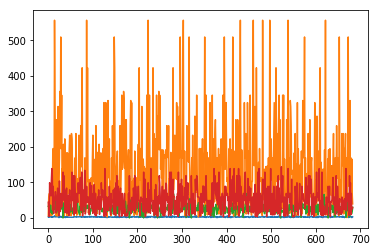

In [45]:
data_copy['Rooms'].plot(), data_copy['crime_C_average'].plot(), data_copy['travel_min_to_CBD'].plot(), data_copy['Age'].plot()

#### Linear model without transforamtion

In [46]:
x_train, x_test, y_train, y_test = train_test_split(data_copy[['Rooms', 'crime_C_average', 'travel_min_to_CBD','Age']],
                                                    data_copy.Price,test_size=0.2,
                                                    random_state=111)
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
print("R2 score - ",lin_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred, y_test))

R2 score -  0.4294388215504456
MSE -  358318616041.3758


### Z-scale transformation

In [47]:
# Scaling data
z_scale = preprocessing.StandardScaler().fit(data_copy[['Price']])
df_z = z_scale.transform(data_copy[['Rooms','crime_C_average', 'travel_min_to_CBD','Age']]) 

In [49]:
# adding to df
data_copy['z_Rooms'] = df_z[:,0]
data_copy['z_crime_C_average'] = df_z[:,1]
data_copy['z_travel_min_to_CBD'] = df_z[:,0] 
data_copy['z_Age'] = df_z[:,1]
data_copy.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,z_Rooms,z_crime_C_average,z_travel_min_to_CBD,z_Age
0,3,6.33,33,44.0,635000.0,-1.647281,-1.647276,-1.647281,-1.647276
1,4,58.56,32,22.0,1305000.0,-1.647280,-1.647193,-1.647280,-1.647193
2,2,68.30,35,4.0,575000.0,-1.647283,-1.647177,-1.647283,-1.647177
3,3,68.30,31,99.0,1400000.0,-1.647281,-1.647177,-1.647281,-1.647177
4,3,25.22,17,79.0,1225000.0,-1.647281,-1.647246,-1.647281,-1.647246


Plotting after z-scale transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x221598eaa20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x221598eaa20>)

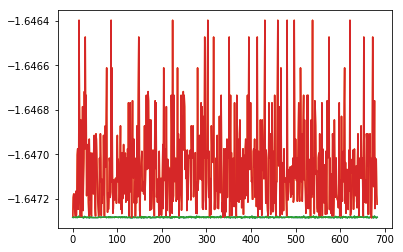

In [50]:
data_copy['z_Rooms'].plot(), data_copy['z_crime_C_average'].plot(), data_copy['z_travel_min_to_CBD'].plot(), data_copy['z_Age'].plot()

Creating linear model with scaled values

In [51]:
x_train, x_test, y_train, y_test = train_test_split(data_copy[['z_Rooms', 'z_crime_C_average', 'z_travel_min_to_CBD','z_Age']],
                                                    data_copy.Price,test_size=0.2,
                                                    random_state=111)
z_model = LinearRegression()
z_model.fit(x_train, y_train)
y_pred = z_model.predict(x_test)
print("R2 score - ",z_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred, y_test))

R2 score -  0.3109669509187565
MSE -  432720237336.2831


### MinMax normalization

In [52]:
# using minmax normalization
minmax_scaler = preprocessing.MinMaxScaler().fit(data_copy[['Price']])
df_mm = minmax_scaler.transform(data_copy[['Rooms','crime_C_average','travel_min_to_CBD','Age']])
data_copy['mm_Rooms']=df_mm[:,0]
data_copy['mm_crime_C_average']=df_mm[:,1]
data_copy['mm_travel_min_to_CBD']=df_mm[:,2]
data_copy['mm_Age']=df_mm[:,3]

Model with Minmax normalized predictors

In [53]:
x_train, x_test, y_train, y_test = train_test_split(data_copy[['mm_Rooms', 'mm_crime_C_average', 'mm_travel_min_to_CBD','mm_Age']],
                                                    data_copy.Price,test_size=0.2,
                                                    random_state=111)
mm_model = LinearRegression()
mm_model.fit(x_train, y_train)
mm_pred = z_model.predict(x_test)
print("R2 score - ",mm_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred, y_test))

R2 score -  0.42943882155156027
MSE -  432720237336.2831


Plotting values after MinMax normalization

(<matplotlib.axes._subplots.AxesSubplot at 0x22159bc0a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22159bc0a90>)

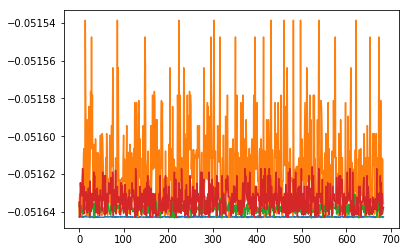

In [54]:
data_copy['mm_Rooms'].plot(), data_copy['mm_crime_C_average'].plot(), data_copy['mm_travel_min_to_CBD'].plot(), data_copy['mm_Age'].plot()

### Log transformation
Transforming predictors into log values

In [55]:
# Iterating through all rows and converting to log values for each col
for index, row in data_copy.iterrows(): 
    data_copy.loc[index, 'log_Rooms'] = log(row.Rooms)
    data_copy.loc[index, 'log_crime_C_average'] = log(row.crime_C_average)
    data_copy.loc[index, 'log_travel_min_to_CBD'] = 0
    data_copy.loc[index, 'log_Age'] = log(row.Age)
    

Model with log transformed values

In [56]:
x_train, x_test, y_train, y_test = train_test_split(data_copy[['log_Rooms', 'log_crime_C_average', 'log_travel_min_to_CBD','log_Age']],
                                                    data_copy.Price,test_size=0.2,
                                                    random_state=111)
log_model = LinearRegression()
log_model.fit(x_train, y_train)
y_pred = log_model.predict(x_test)
print("R2 score - ",log_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred, y_test))

R2 score -  0.2823888147622372
MSE -  450667617185.1407


Plotting values after transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x22159a8d6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22159a8d6d8>)

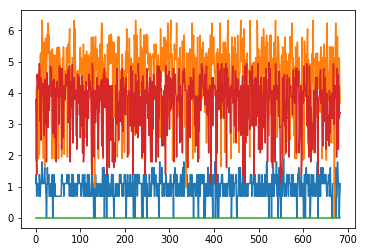

In [57]:
data_copy['log_Rooms'].plot(), data_copy['log_crime_C_average'].plot(), data_copy['log_travel_min_to_CBD'].plot(), data_copy['log_Age'].plot()

#### Square root transformation
Doing a sqroot transformation and creating a linear model

In [58]:
for index, row in data_copy.iterrows(): 
    data_copy.loc[index, 'sqrt_Rooms'] = sqrt(row['Rooms'])
    data_copy.loc[index, 'sqrt_crime_C_avg'] = sqrt(row['crime_C_average'])
    data_copy.loc[index, 'sqrt_travel_min_to_CBD'] = sqrt(row['travel_min_to_CBD'])
    data_copy.loc[index, 'sqrt_Age'] = sqrt(row['Age'])
    
x_train, x_test, y_train, y_test = train_test_split(data_copy[['sqrt_Rooms', 'sqrt_crime_C_avg', 'sqrt_travel_min_to_CBD','sqrt_Age']],
                                                data_copy.Price,test_size=0.2,
                                                random_state=1112)
sqrt_model = LinearRegression()
sqrt_model.fit(x_train, y_train)

y_pred_5 = sqrt_model.predict(x_test)

print("R2 score - ",sqrt_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred_5, y_test))

R2 score -  0.2994513008006737
MSE -  367202124101.6304


Plotting values after transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x221599fb518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x221599fb518>)

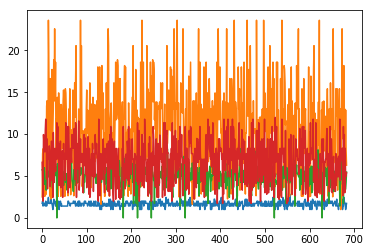

In [59]:
data_copy['sqrt_Rooms'].plot(), data_copy['sqrt_crime_C_avg'].plot(), data_copy['sqrt_travel_min_to_CBD'].plot(), data_copy['sqrt_Age'].plot()

### Power Transformation
Doing a power transformation on predictors and creating predictors. 

In [60]:
for index, row in data_copy.iterrows(): 
    data_copy.loc[index, 'sq_Rooms'] = row['Rooms'] **2
    data_copy.loc[index, 'sq_crime_C_average'] = row['crime_C_average']**2
    data_copy.loc[index, 'sq_travel_min_to_CBD'] = row['travel_min_to_CBD']**2
    
x_train, x_test, y_train, y_test = train_test_split(data_copy[['sq_Rooms', 'sq_crime_C_average', 'sq_travel_min_to_CBD','Age']],
                                                data_copy.Price,test_size=0.2,
                                                random_state=1112)
sq_model = LinearRegression()
sq_model.fit(x_train, y_train)

y_pred_6 = sq_model.predict(x_test)

print("R2 score - ",sq_model.score(x_test, y_test))
print("MSE - ",mean_squared_error(y_pred_6, y_test))

R2 score -  0.30378241652842264
MSE -  364931910914.7712


Plotting values after transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x22159a8c390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22159a8c390>)

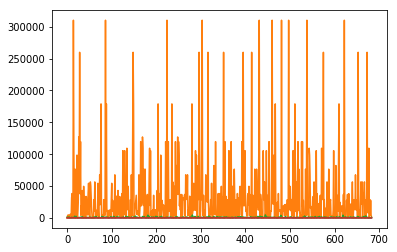

In [61]:
data_copy['sq_Rooms'].plot(), data_copy['sq_crime_C_average'].plot(), data_copy['sq_travel_min_to_CBD'].plot(), data_copy['Age'].plot()

#### Summarizing transformation results for linear model fit
From the RMSE values looks like MinMax transformation finds the best predictors values for fitting the model against Price. 

### References

   1. H., Dunn, M., Anderson, J., G, V., Malyutin, S., & kavvuri, p. (2019). Haversine Formula in Python (Bearing and Distance between two GPS points). Retrieved from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
   2. Haversine formula. (2019). Retrieved from https://en.wikipedia.org/wiki/Haversine_formula